# 5] Exercise: Apply Logistic regression to Amazon reviews data set. 


In [1]:
%matplotlib inline
import pandas as pd
import sqlite3
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from string import punctuation
from sklearn import svm
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk
from nltk import ngrams
from itertools import chain
import warnings
warnings.filterwarnings('ignore')

In [2]:
con = sqlite3.connect('/home/rahul/Desktop/MLAAIC/database.sqlite')
df = pd.read_sql_query("""SELECT * FROM Reviews""",con)  

## Data Preprocessing

In [3]:
df = df.dropna()
df['review'] = np.where(df['Score']>3, 'positive', 'negative')
df_sample = df
sorted_data=df_sample.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [4]:
DataPoints, Features = final.shape
l= final["review"].unique()
x,y= final["review"].value_counts()
print("Final Data \n")
# print(len(l))
print ("Total number of Datapoints -",DataPoints,'\n\n'
      'Total Number Features or Independent Variable -',Features-1,'\n')
print('The Positive review has label \"{}\" and \"{}\" datapoint \n'.format(l[0],x))
print('The Negatve review has class label \"{}\" and \"{}\" datapoints'.format(l[1],y))

Final Data 

Total number of Datapoints - 393931 

Total Number Features or Independent Variable - 10 

The Positive review has label "positive" and "307052" datapoint 

The Negatve review has class label "negative" and "86879" datapoints


### Text preprocessing

In [5]:
import itertools

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext.lower()
final['CleanedText']=list(map(cleanhtml,final['Text']))


In [6]:
#-----------------------
# Suggestion -1.a 
# Not balncing data
#-----------------------

# positive_reviews = final[final.review=='positive']
# negative_reviews = final[final.review=='negative']
# # https://pandas.pydata.org/pandas-docs/version/0.17.0/generated/pandas.DataFrame.sample.html
# negative_reviews = negative_reviews.sample(50000)
# positive_reviews = positive_reviews.sample(50000)
# # https://pandas.pydata.org/pandas-docs/stable/generated/pandas.concat.html
# final_sample = pd.concat([positive_reviews, negative_reviews])


In [13]:
# # # creating dataset by removing unwanted data
# X_c = final[['Time','review','CleanedText']]
# X_c = X_c.sort_values(['Time'],ascending=True)

# #-----------------------
# # Suggestion -1.b 
# # Take top 100k from sorted dataframe
# #-----------------------
# X_c =X_c[:100000]
# X = X_c['CleanedText']
# Y = X_c['review']


In [11]:
# http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html
# encoding label data
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
Y = le.fit_transform(Y)

In [25]:
#-----------------------
# Suggestion - 2 
# train_test split, maintain time. 60K-40K
#-----------------------

X_train = X[:60000] 
Y_train = Y[:60000]
# len(Y_train)== len(X_train)
X_test = X[60000:] 
Y_test = Y[60000:]
# len(Y_test)== len(X_test)


# Grid Search

In [26]:
#https://www.kaggle.com/laowingkin/amazon-fine-food-review-sentiment-analysis
vectorizer = CountVectorizer(stop_words = 'english')
BoW = vectorizer.fit_transform(X_train)

In [27]:
tfidf = TfidfVectorizer(stop_words='english')
tf_idf = tfidf.fit_transform(X_train)

In [33]:
#-----------------------
# Suggestion - 3 
# It is k-fold cross validation for time series data
#ref- https://stackoverflow.com/questions/46732748/
#     how-do-i-use-a-timeseriessplit-with-a-gridsearchcv-object-to-tune-a-model-in-sci
#  
#  seggestion -4
#   Data leakeage problem solved by: (https://machinelearningmastery.com/data-leakage-machine-learning/)
#   1.Tempmoral Cutoff- used Time based split
#   2.Using hold out test X_test for final sanity check
#   
#-----------------------


tuned_parameters = [{'penalty': ['l1'],'C': [10**-4, 10**-2, 10**0, 10**2, 10**4]},
                    {'penalty': ['l2'], 'C': [10**-4, 10**-2, 10**0, 10**2, 10**4]}]


from sklearn.model_selection import GridSearchCV,TimeSeriesSplit,validation_curve
# from sklearn.linear_model import LogisticRegression

# tscv = TimeSeriesSplit(n_splits=2)
my_cv = TimeSeriesSplit(n_splits=2).split(BoW)
my_cv2 = TimeSeriesSplit(n_splits=2).split(tf_idf)
#BoW
modelBoW = GridSearchCV(LogisticRegression(), tuned_parameters,scoring = 'f1', cv=my_cv)
modelBoW.fit(BoW, Y_train)
#TFiDF
model_tf = GridSearchCV(LogisticRegression(), tuned_parameters,scoring = 'f1', cv=my_cv2)
model_tf.fit(tf_idf, Y_train)


GridSearchCV(cv=<generator object TimeSeriesSplit.split at 0x7fbae8b39eb8>,
       error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'C': [0.0001, 0.01, 1, 100, 10000], 'penalty': ['l1']}, {'C': [0.0001, 0.01, 1, 100, 10000], 'penalty': ['l2']}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1', verbose=0)

#### Note after label encoding "positive" is "class-1" and "negative" is "class0"

In [34]:
BoW_Grid = pd.DataFrame.from_dict(modelBoW.cv_results_)
Tf_IDF_Grid = pd.DataFrame.from_dict(model_tf.cv_results_)

# Random search

In [37]:
from sklearn.model_selection import RandomizedSearchCV

#https://chrisalbon.com/machine_learning/model_selection/hyperparameter_tuning_using_random_search/
from scipy.stats import uniform
# Create regularization penalty space
penalty = ['l1', 'l2']

# Create regularization hyperparameter distribution using uniform distribution
C = uniform(loc=0, scale=4)

# Create hyperparameter options
hyperparameters = dict(C=C, penalty=penalty)
my_cv = TimeSeriesSplit(n_splits=2).split(BoW)
my_cv2 = TimeSeriesSplit(n_splits=2).split(tf_idf)

#BoW
modelBoWr=RandomizedSearchCV(LogisticRegression(),  hyperparameters,scoring = 'f1', cv=my_cv)
modelBoWr.fit(BoW, Y_train)

#TFiDF
model_tfr = RandomizedSearchCV(LogisticRegression(),  hyperparameters,scoring = 'f1', cv=my_cv2)
model_tfr.fit(tf_idf, ytest)

NameError: name 'ytest' is not defined

In [14]:
BoW_Rcv = pd.DataFrame.from_dict(modelBoWr.cv_results_)
Tf_IDF_Rcv = pd.DataFrame.from_dict(model_tfr.cv_results_)

## L1 and L2 regularization

In [15]:
from sklearn.metrics import accuracy_score
#BoW -penalty l1

clfBoW = LogisticRegression(penalty = 'l1')
clfBoW.fit( X_train,y_train)
predBoW=clfBoW.predict(X_test)
Accuracy=round(accuracy_score(y_test,predBoW,normalize=True),4)

#BoW -penalty l2

clfBoW2 = LogisticRegression(penalty = 'l2')
clfBoW2.fit( X_train,y_train)
predBoW2=clfBoW2.predict(X_test)
Accuracy2=round(accuracy_score(y_test,predBoW2,normalize=True),4)

#Tf-IDF -penalty l1

clftf = LogisticRegression(penalty = 'l1')
clftf.fit( Xtrain,ytrain)
predtf=clftf.predict(Xtest)
Accuracy3=round(accuracy_score(ytest,predtf,normalize=True),4)

#Tf-IDF -penalty l2

clftf1 = LogisticRegression(penalty = 'l1')
clftf1.fit( Xtrain,ytrain)
predtf1=clftf1.predict(Xtest)
Accuracy4=round(accuracy_score(ytest,predtf1,normalize=True),4)


## labda vs Sparsity vs Error
### http://scikit-learn.org/stable/auto_examples/linear_model/plot_logistic_l1_l2_sparsity.html#sphx-glr-auto-examples-linear-model-plot-logistic-l1-l2-sparsity-py

In [16]:
C=[0.001,0.005,0.01,0.05,0.1,0.5,1,10,25,50,35,100]
Score=[]#Error 
Sparse=[]#Sparsity


for i in C:
    clf = LogisticRegression(C=i, penalty='l1')
    clf.fit(X_train, y_train)
    pred=clf.predict(X_test)
    accuracy=round(accuracy_score(y_test,pred,normalize=True),4)
   
    S=1-round(accuracy,5)
    Score.append(S)
    Sp =np.count_nonzero(clf.coef_)
    Sparse.append(Sp)

## Multi colinearity and feature importance

In [17]:
w = tfidf.get_feature_names()
coef = clftf.coef_.tolist()[0]
coeff_df = pd.DataFrame({'Word' : w, 'Coefficient' : coef})
coeff_df = coeff_df.sort_values(['Coefficient', 'Word'], ascending=[0, 1])
print('')
print('-Top 20 positive-')
print(coeff_df.head(20).to_string(index=False))
print('')
print('-Top 20 negative-')        
print(coeff_df.tail(20).to_string(index=False))


-Top 20 positive-
Coefficient        Word
  11.298174      hooked
  10.647343      highly
  10.441436       great
  10.056896   delicious
   9.904148        best
   9.782654     perfect
   9.207436   excellent
   8.682665  pleasantly
   7.985880   wonderful
   7.697510     pleased
   7.575350       loves
   7.432821   skeptical
   7.280186        glad
   7.249619        love
   7.246018     awesome
   7.180631     amazing
   6.913862       yummy
   6.691701         yum
   6.499431   fantastic
   6.425793       thank

-Top 20 negative-
Coefficient            Word
  -6.326188           bland
  -6.401144          beware
  -6.493830           threw
  -6.526257          return
  -6.757395       tasteless
  -6.939167      disgusting
  -6.984046        whopping
  -7.219341        mediocre
  -7.346168          hoping
  -7.939053        horrible
  -8.123101            okay
  -8.194282              ok
  -8.575561    disappointed
  -8.777331           hopes
  -9.002043           awful
  -9.11335

## Results

In [32]:
from prettytable import PrettyTable
x = PrettyTable()
x.field_names = ["Model", "Model Selection Method","penalty", "Optimal lambda"]

x.add_row(["BoW", "GridSearch", modelBoW.best_estimator_.get_params()['penalty'],
           modelBoW.best_estimator_.get_params()['C']],)
# x.add_row(["TF-IDF", "GridSearch", model_tf.best_estimator_.get_params()['penalty'],
#            model_tf.best_estimator_.get_params()['C']])
# x.add_row(["BoW", "Rondomized CV", modelBoWr.best_estimator_.get_params()['penalty'],
#           round(modelBoWr.best_estimator_.get_params()['C'],4)])
# x.add_row(["TF-IDF", "Rondomized CV", model_tfr.best_estimator_.get_params()['penalty'],
#           round(model_tfr.best_estimator_.get_params()['C'],4)])

print('Table 1 - Optimal Value of Lambda, Train error and test error')
print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')

# print(x.get_string(title="Australian cities"))
print(x)


Table 1 - Optimal Value of Lambda, Train error and test error
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
+-------+------------------------+---------+----------------+
| Model | Model Selection Method | penalty | Optimal lambda |
+-------+------------------------+---------+----------------+
|  BoW  |       GridSearch       |    l2   |       1        |
+-------+------------------------+---------+----------------+


In [31]:
y = PrettyTable()
y.field_names = ["Model","penalty", "Acuuracy"]

y.add_row(["BoW", "L1",round(Accuracy*100,2)])
# y.add_row(["BoW", "L2",round(Accuracy2*100,2)])
# y.add_row(["TfIDf", "L1",round(Accuracy3*100,2)])
# y.add_row(["TfIDF", "L2",round(Accuracy4*100,2)])


print('Table 2 - L1 and L2 regularization')
print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')

# print(x.get_string(title="Australian cities"))
print(y)

NameError: name 'Accuracy' is not defined

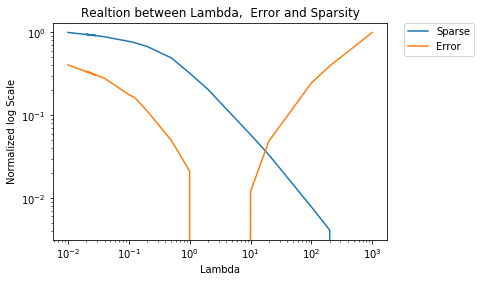

In [20]:
#https://stackoverflow.com/questions/22276066/how-to-plot-multiple-functions-on-the-same-figure-in-matplotlib
from sklearn import preprocessing
# [0.001,0.005,0.01,0.05,0.1,0.5,1]
#scaling to plot them
Sparse =np.array(Sparse)
Sparse.reshape(1,-1)
Score = np.array(Score)
Score.reshape(1,-1)

Sparse_normalized = (Sparse-min(Sparse))/(max(Sparse)-min(Sparse))
Score_normalized = (Score-min(Score))/(max(Score)-min(Score))

C=np.array(C)
lambd=1/C
#https://matplotlib.org/users/legend_guide.html
plt.loglog(lambd, Sparse_normalized, label='Sparse') # plotting t, a separately 
plt.loglog(lambd, Score_normalized, label='Error') # plotting t, b separately 
plt.xlabel('Lambda')
plt.ylabel('Normalized log Scale')
plt.title('Realtion between Lambda,  Error and Sparsity')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()